# Stationarity

In this section we will cover
- Definition of stationarity and examples of common stationary and nonstationary time series.
- How to detect stationarity.
- The most common ways to transform nonstationary time series into stationary ones.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
np.random.seed(42) # Reproducibility

ModuleNotFoundError: No module named 'matplotlib'

---

### Why do we care about stationarity?

- Stationarity is a key assumption to time series analysis.
- Without it many basic time series models would break.
- Transformations can be applied to convert a nonstationary time series to a stationary one.

### What is stationarity?

- Intuition: a time series is stationary when there are no changes in the underlying system that generates it.
- We define it to be:

    - Constant mean (no trend).
    - Constant variance (no heteroskedasticity).
    - Constant autocorrelation structure.
    - No periodic component.

- Let's create an utility function to make plots.

In [7]:
def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

- First, we create a variable `time` that defines equally-spaced time intervals.
- Then we'll sample values from a Normal distribution with a mean of 0 and a standard deviation of 1.
- Essentially we're creating white noise, which is a stationary time series as it exhibits all the properties required of a stationary time series.

In [8]:
T = 200
time = np.arange(T)
stationary = np.random.normal(loc=0, scale=1.0, size=(T))

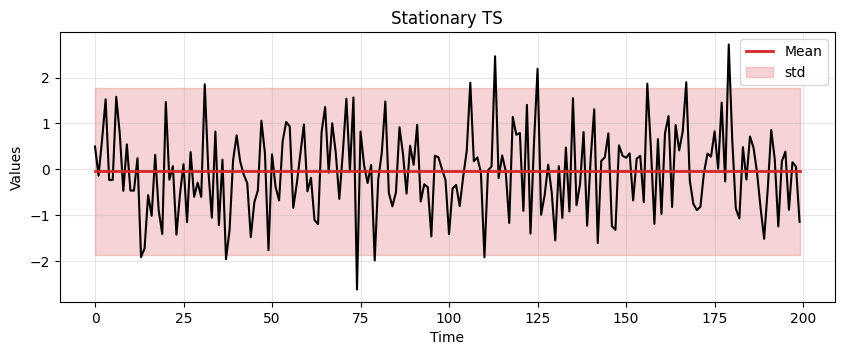

In [9]:
ax = run_sequence_plot(time, stationary, title="Stationary TS")
ax.plot(time, np.ones_like(time)*np.mean(stationary), linewidth=2, color='tab:red', label='Mean');
ax.fill_between(time, np.ones_like(time)*(stationary.mean()-1.96*stationary.std()), 
                np.ones_like(time)*(stationary.mean()+1.96*stationary.std()), 
                color='tab:red', alpha=0.2, label='std')
plt.legend();

- We can easily check that the white noise has constant mean, constant variance, and no periodicity.
- What about the autocorrelation?

#### Autocorrelation
- Autocorrelation measures how much the current time series measurement is correlated with a past measurement. 
- For example, today's temperature is often highly correlated with yesterday's temperature. 
- To discuss these things we must introduce the idea of a *lag*, i.e., a delay. 

![Autocorrelation](media/Autocorrelation.gif)

- Say you wanted to know if today's temperature correlates more with yesterday's temperature or the temperature from two days ago. 
- You could test this by computing the correlation between the original time series and the same series delayed 1 time step. 
- The second value of the original time series would be compared with the first of the delayed time series. 
- The third original value would be compared with the second of the delayed. 
- And so on. 

Autocorrelation often results in a pattern, whereas a time series without autocorrelation looks random.

**Example: constant autocorrelation**

- Time series of daily temperature in a specific location over a year. 
- If this location has a very stable climate, the day-to-day changes in temperature might be minimal and consistent throughout the year. 
- Then, the autocorrelation would be relatively constant. 
- E.g., the correlation between today's temperature and tomorrow's temperature is roughly the same as the correlation between the temperature 30 days ago and 29 days ago.

**Example: time-varying autocorrelation**

- Time series representing the daily stock prices of a particular company. 
- Stock prices can be influenced by market trends, company performance, economic indicators, world events, etc... 
- Here, the autocorrelation might be time-dependent. 
- E.g., during a period of market stability, the stock prices might show a consistent pattern over time (e.g., a steady increase). 
- However, during a market upheaval or a significant company event (like a product launch or a scandal), the pattern could change dramatically. 

### Common stationary and nonstationary time series

- If the analytic expression of the time series is known, it is possible to check the conditions for stationarity. 
- In practice, the process generating the time series might be unknown and we'll need other tools to check stationarity.
- Starting the analysis by looking at the `run_sequence_plot` is an excellent starting point. 

#### White noise

- We already looked at this time series and conclude that mean and variance are constant and there is no seasonal component.
- In addition, since the value of each time step is drawn independently, there is no correlation.

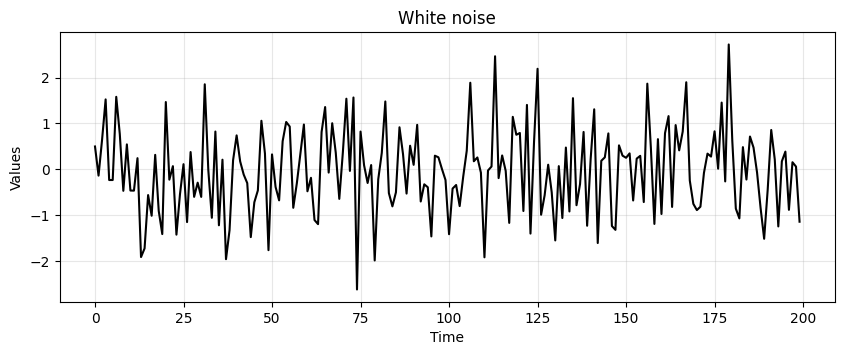

In [10]:
run_sequence_plot(time, stationary, title="White noise");

#### Random walk

- The random walk is one of the most important **nonstationary** time series.
- It is defined as:

$$X(t) = X(t-1) + \epsilon_t$$

- where $\epsilon_t$ are the steps and sampled randomly.
- Let's create a random walk.

In [40]:
seed = 4

rand_walk = np.empty_like(time, dtype='float')
for t in time:
    rand_walk[t] = seed + np.random.normal(loc=0, scale=2.5, size=1)[0]
    seed = rand_walk[t]

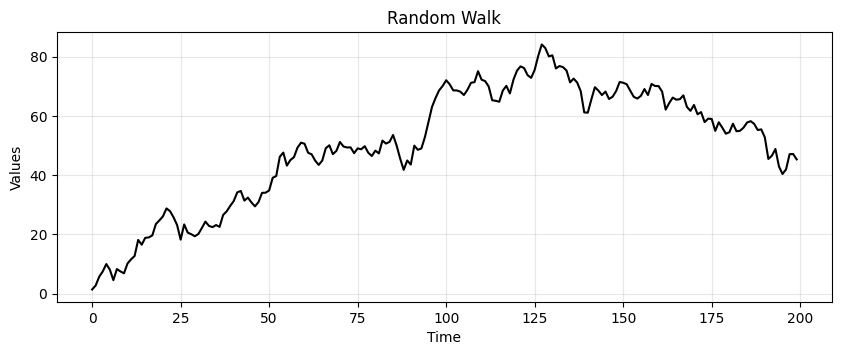

In [41]:
run_sequence_plot(time, rand_walk, title="Random Walk");

- Notice how the current value is highly correlated with the past values and fluctuates much less than the white noise.
- The random walk is nonstationary.

#### Time series with trend

- Consider the following data.

In [70]:
trend = (time * 2.75) + stationary

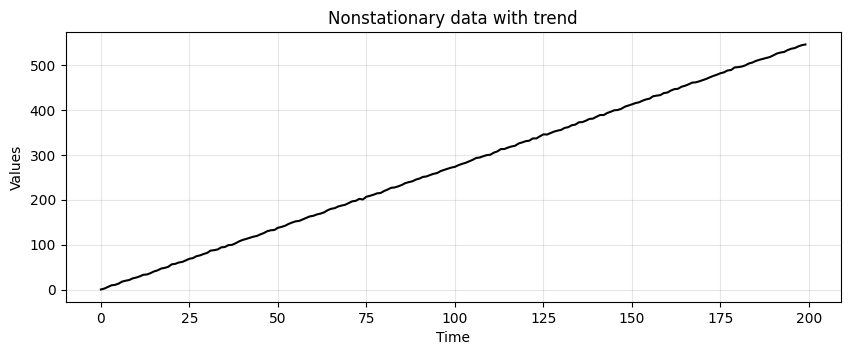

In [71]:
run_sequence_plot(time, trend, title="Nonstationary data with trend");

- Is this data stationary?

- No, the mean changes over time (i.e. there is a trend)

#### Time series with seasonality

In [94]:
seasonality = 10 + np.sin(2*np.pi*time/24)*10

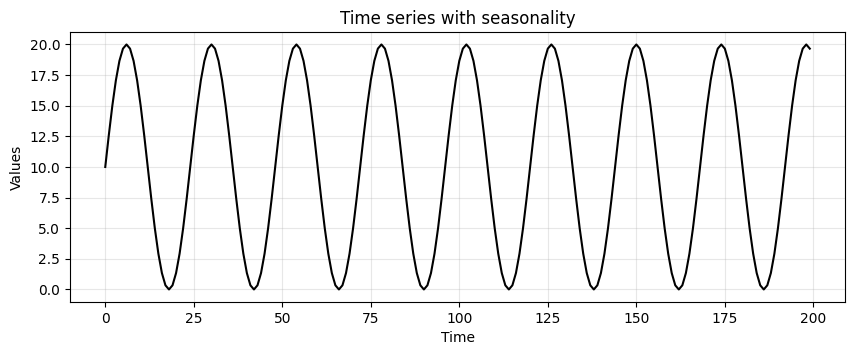

In [95]:
run_sequence_plot(time, seasonality, title="Time series with seasonality");

- Is this time series stationary?

- The mean of a periodic signal over a complete cycle always assumes the same value (`10` in our case).
- However, over an half-cycle or any period not equal to an integer multiple of the full cycle, the mean changes (is different from `10`). 
- This indicates that the mean is not constant over time

![Sin stationary](media/SinStationary.gif)

## Detecting stationarity

Next, we will talk about some techniques used to identify if a time series is stationary or not. 

Specifically, we will focus on the Augmented Dickey-Fuller Test.

### Augmented Dickey-Fuller Test

- This is a statistical procedure to determine whether a time series is stationary or not. 
- We will discuss more details about the test in the next lectures.
- For now, that's what we need to know:
    1. **Null hypothesis:** $H_0$: the series is nonstationary.
    2. **Alternative hypothesis:** $H_A$: the series is stationary.

- Like any statistical test you should set a significance level or threshold that determines whether you should accept or reject the null. 
- The values $\alpha=0.05$ or $\alpha=0.01$, which yield a confidence of $95\%$ and $99\%$, respectively, are common choices.

Example: $p = 0.0001 \rightarrow$ reject $H_0 \rightarrow$ the time series is stationary

Example: $p = 0.43 \rightarrow$ fail to reject $H_0 \rightarrow$ the time series is non-stationary

#### Stationary Data & ADF

- Let's see how to run this test in Python.

In [72]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(stationary)

- Let's see and comment the main outputs from the ADF test. 

In [73]:
print(f"ADF: {adf:.2f}")

ADF: -14.74


- First, `adf` is the value of the test statistic. 
- The more negative the value, the more confident we can be that the series is stationary. 
- Here we see a negative value. 
- That may not mean anything to you just yet but `pvalue` should.

In [74]:
print(f"p-value: {pvalue}")

p-value: 2.543125112212854e-27


- The `pvalue` is interpreted like any p-value. 
- The `pvalue` should be compared with the confidence levels (e.g., $\alpha=0.05$ or $\alpha=0.01$).
- Based on the comparison, we reject or fail to reject $H_0$. 
- Here ``pvalue`` is very close to zero so we **reject** the $H_0$ in favor of $H_A$ and conclude that the time series is stationary.

In [75]:
print(f"nobs: {nobs}")

nobs: 199


- The variable `nobs` is simply the number of observations in the time series.

In [76]:
print(f"critical values: {critical_values}")

critical values: {'1%': np.float64(-3.4636447617687436), '5%': np.float64(-2.8761761179270766), '10%': np.float64(-2.57457158581854)}


- Finally, ``critical_values`` are the test statistic thresholds for common significant levels. 
- Here we see a test statistic lower than -2.87 is sufficient to reject $H_0$ at a significance level of 5%.

- You may have noticed two outputs we didn't discuss. 
- See [statsmodels docs](http://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) for a description of ``usedlag`` and ``icbest``.

#### ADF on time series with trend
- Next, we run the ADF test on the `trend` time series. 

In [77]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(trend, regression='c')
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")
print(f"critical values: {critical_values}")

ADF: 0.10
p-value: 0.966
critical values: {'1%': np.float64(-3.4654311561944873), '5%': np.float64(-2.8769570530458792), '10%': np.float64(-2.574988319755886)}


- As expected, we fail to reject $H_0$ that the `trend` time series is nonstationary.

### ADF on random walk

- Finally, we run the ADF test on the `rand_walk` time series.

In [78]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(rand_walk, regression='c')
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")
print(f"critical values: {critical_values}")

ADF: -2.43
p-value: 0.134
critical values: {'1%': np.float64(-3.4638151713286316), '5%': np.float64(-2.876250632135043), '10%': np.float64(-2.574611347821651)}


- As we discussed before, the random walk is nonstationary because its variance $\sigma^2t$ is not constant over time.

---

## Common transformations to achieve stationarity

- There are several ways to transform nonstationary time series data:

Transformation | Effect
:---|:---
Subtract trend | Constant mean
Apply log | Constant variance
Differencing | Remove autocorrelation 
Seasonal differencing | Remove periodic component

- Sometimes you'll have to do multiple transformations on the same dataset.
- Note that this is just a small subset of the total possible ways to transform nonstationary time series. 
- We'll focus on subtracting the trend and seasonal differencing for now

### Subtract estimated trend & seasonality

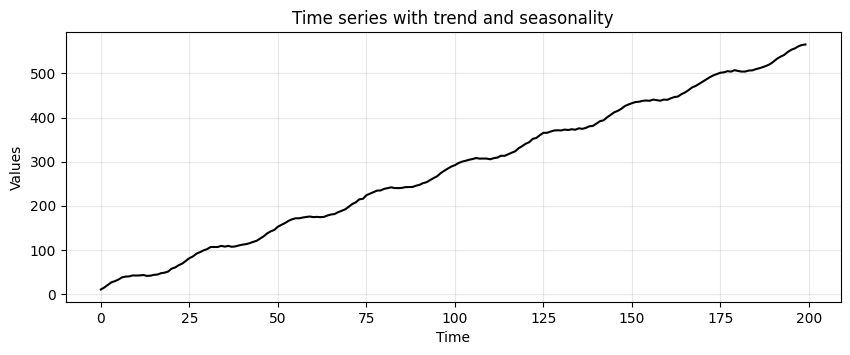

In [96]:
trend_seasonality = trend + seasonality
run_sequence_plot(time, trend_seasonality, title="Time series with trend and seasonality");

In [97]:
adf_b4, pvalue_b4, _, _, _, _ = adfuller(trend_seasonality)
print(f"ADF: {adf_b4:.2f}")
print(f"p-value: {pvalue_b4:.3f}")

ADF: -0.28
p-value: 0.929


- Nonstationary as expected. 
- Next, we apply the decomposition.

In [113]:
ss_decomposition = seasonal_decompose(x=trend_seasonality, model='additive', period=24)
est_trend = ss_decomposition.trend
est_seasonal = ss_decomposition.seasonal
est_noise = ss_decomposition.resid

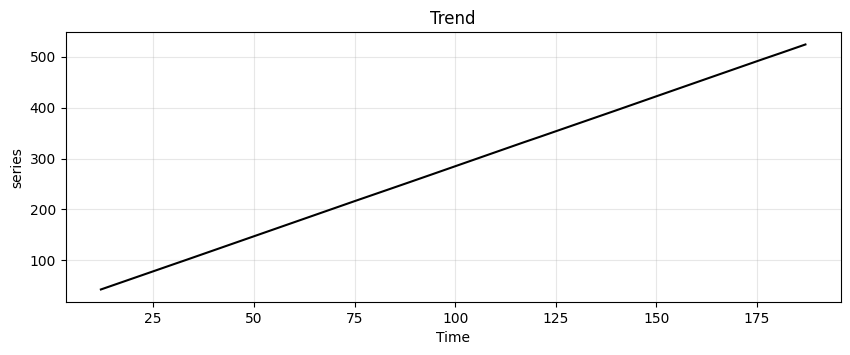

In [111]:
run_sequence_plot(time, est_trend, title="Trend", ylabel="series");

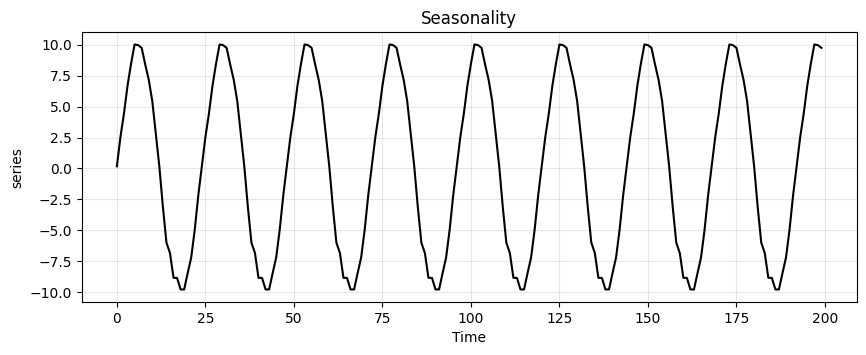

In [112]:
run_sequence_plot(time, est_seasonal, title="Seasonality", ylabel="series");

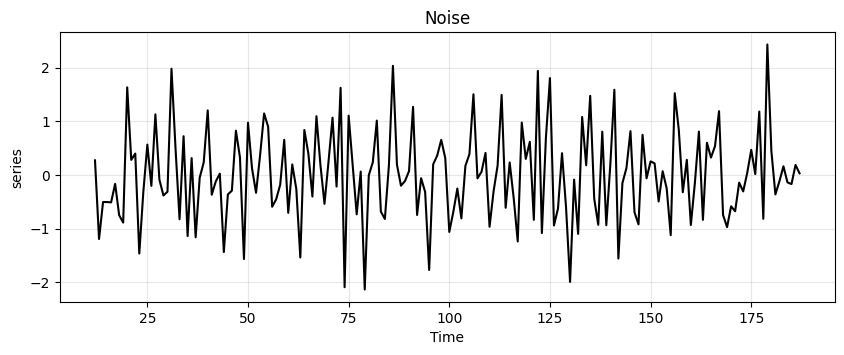

In [114]:
run_sequence_plot(time, est_noise, title="Noise", ylabel="series");

- Let's look at the residual values.

In [115]:
print(est_residual[:20])
print('...')
print(est_residual[-20:])

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
  0.27211609 -1.19594945 -0.50444018 -0.50638219 -0.51225125 -0.16578987
 -0.75150172 -0.88957711]
...
[ 0.44755405 -0.36391449 -0.11867315  0.16158118 -0.13943343 -0.1707093
  0.18690891  0.02980826         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan]


- We'll have to remove the first $12$ and last $12$ values to run an ADF test since those are `nan`. 
- The number 12 is due to the fact that the method applies seasonal differencing and we specified `period=24`.
- Here's how to do that and run the test all in one call.

In [117]:
adf_after, pvalue_after, _, _, _, _ = adfuller(est_noise[12:-12])
print(f"ADF: {adf_after:.2f}")
print(f"p-value: {pvalue_after:.3f}")

ADF: -6.19
p-value: 0.000


- Now the time series is stationary

### Seasonal differentiation

- Consider a time series with a seasonality of period $L$.
- There will be a strong correlation between $X(t)$ and $X(t+L)$.
- Seasonal differentiation can remove the seasonality and make the time series stationary:

$$\hat{X}(t) = X(t+L) - X(t)$$

- After seasonal differencing the time series will become $L$ steps shorter.
- Note that we can perform the standard differentiation in cascade to seasonal differentiation if we need to remove also the trend on top of the seasonality.
- Let's see this on the `trend_seasonality` time series.

![Seasonal Differencing](media/SeasonalDifferencing.gif)

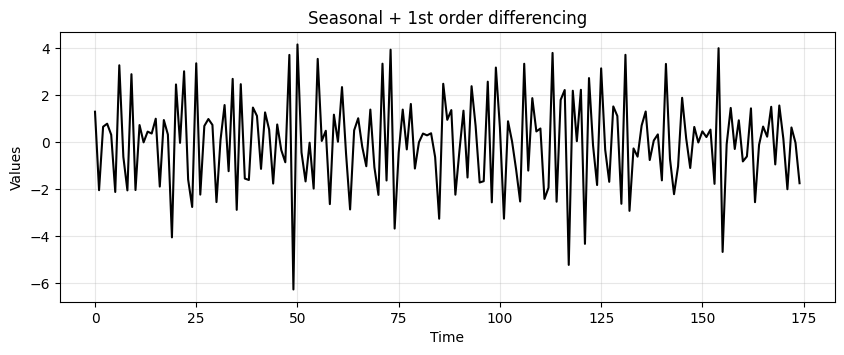

In [122]:
trend_seasonality_d24 = (trend_seasonality[:-24] 
                         - trend_seasonality[24:]) # remove seasonality
trend_seasonality_d24_d1 = (trend_seasonality_d24[:-1] 
                            - trend_seasonality_d24[1:]) # remove trend

# Plot the differenced time series
run_sequence_plot(time[:-25], trend_seasonality_d24_d1, title="Seasonal + 1st order differencing");

## Summary

In this lecture we learned: 
1. What does it mean for a time series to be stationary.
2. A set of notable stationary and nonstationary time series.
2. Common tools to identify stationarity.
3. Useful nonstationary-to-stationary transformations.

---

In [121]:
# TODO: Exercises